In [170]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import numpy as np
import os
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

## Retrieving and splitting data 

In [162]:
df = pd.read_csv('training_dataset.csv')
X = df.loc[:, 'rms_mean':]
y = df['classID']

folds = [(df.loc[df['fold'] != i].index, df.loc[df['fold'] == i].index) for i in range(1, 11)]

##  Some PCA

In [164]:
std_sc = StandardScaler()
pca_2 = PCA(n_components = 0.9)

X_tr = std_sc.fit_transform(X)
X_tr_pca = pca_2.fit_transform(X_tr)

In [165]:
exp_var = pca_2.explained_variance_ratio_
exp_var

array([0.26093785, 0.17512426, 0.11918205, 0.05058636, 0.04604063,
       0.03842099, 0.03079203, 0.0265232 , 0.02362433, 0.01958917,
       0.01708156, 0.01601189, 0.01539716, 0.0152195 , 0.01403009,
       0.01366582, 0.01325071, 0.01111564])

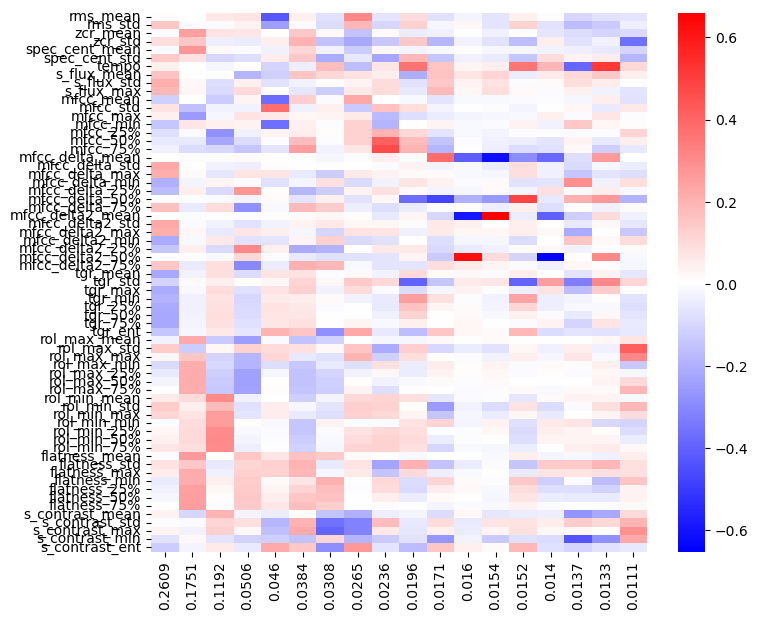

In [166]:
fig, ax = plt.subplots(figsize = (8, 7))
sns.heatmap(pca_2.components_.T, cmap ='bwr', annot = False, ax = ax,
            yticklabels = X.columns, xticklabels = np.round(exp_var, 4));

In [101]:
class CustomLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_one=True):
        self.add_one = add_one

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        if self.add_one:
            # Add 1 to avoid log(0) errors
            X_transformed = np.log(X + 1)
        else:
            # Handle case where values allow direct log transformation
            X_transformed = np.log(X)
        return X_transformed

In [161]:
df.columns

Index(['slice_file_name', 'classID', 'fold', 'rms_mean', 'rms_std', 'zcr_mean',
       'zcr_std', 'spec_cent_mean', 'spec_cent_std', 'tempo', 's_flux_mean',
       's_flux_std', 's_flux_max', 'mfcc_mean', 'mfcc_std', 'mfcc_max',
       'mfcc_min', 'mfcc_25%', 'mfcc_50%', 'mfcc_75%', 'mfcc_delta_mean',
       'mfcc_delta_std', 'mfcc_delta_max', 'mfcc_delta_min', 'mfcc_delta_25%',
       'mfcc_delta_50%', 'mfcc_delta_75%', 'mfcc_delta2_mean',
       'mfcc_delta2_std', 'mfcc_delta2_max', 'mfcc_delta2_min',
       'mfcc_delta2_25%', 'mfcc_delta2_50%', 'mfcc_delta2_75%'],
      dtype='object')

## Logistic Regression

### With log transformations

In [169]:
log_features = ['rms_mean', 'rms_std', 'zcr_mean', 'zcr_std', 'spec_cent_std',
            's_flux_std', 's_flux_max', 'mfcc_delta_max', 'mfcc_delta_std', 
            'mfcc_delta_75%', 'mfcc_delta2_std', 'mfcc_delta2_max', 'mfcc_delta2_75%']

preprocessor = ColumnTransformer(transformers = [
    ('log', CustomLogTransformer(), log_features),
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', LogisticRegression())
    ]
)

param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [1e-3, 1e-1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga']
}

logreg_log = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

logreg_log.fit(X, y)
print(f"Best: {logreg_log.best_score_} using {logreg_log.best_params_}")

Best: 0.6515414180606804 using {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [173]:
class_dict = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

### Without log transformations 

In [167]:
preprocessor = ColumnTransformer(transformers = [
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', LogisticRegression())
    ]
)

param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [1e-3, 1e-1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga']
}

logreg = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

logreg.fit(X, y)
print(f"Best: {logreg.best_score_} using {logreg.best_params_}")

Best: 0.6611187892552222 using {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


## XGBoost

In [168]:
preprocessor = ColumnTransformer(transformers = [
    ('ss', StandardScaler(), X.columns)
])

# Create the pipeline
pipeline = Pipeline(steps= [
    ('pp', preprocessor),
    ('model', XGBClassifier())
    ]
)

param_grid = {
    'model__eta': [0.01, 0.1, 0.3],
    'model__max_depth': [2, 6, 10],
    'model__n_estimators': [100, 300, 500]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = folds, scoring = 'accuracy')

gs.fit(X, y)
print(f"Best: {gs.best_score_} using {gs.best_params_}")

Best: 0.6864914171160094 using {'model__eta': 0.3, 'model__max_depth': 6, 'model__n_estimators': 500}


### Feature Importances

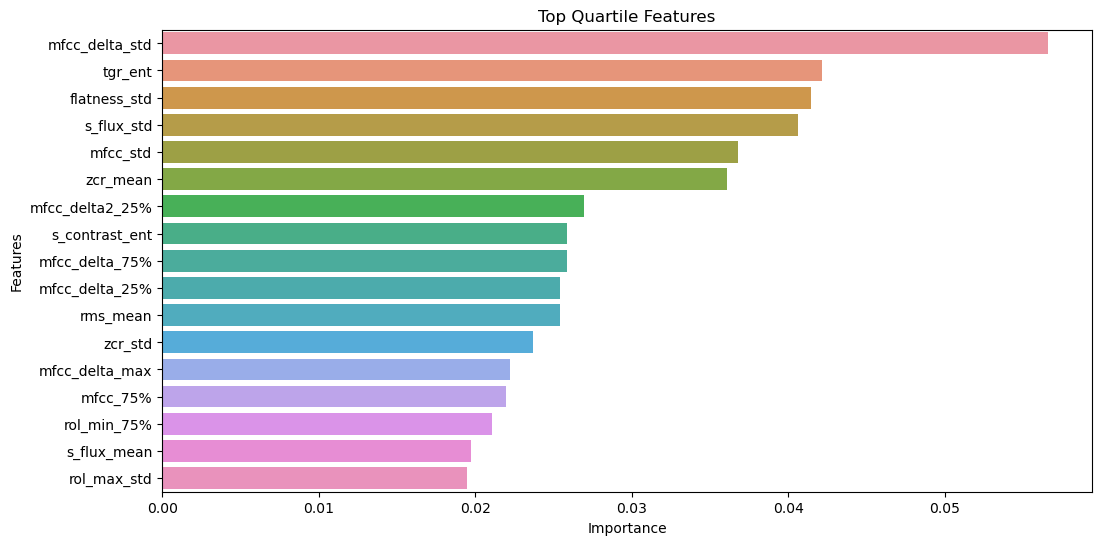

In [280]:
cv_results = pd.DataFrame(gs.cv_results_)
best_estimator = gs.best_estimator_
feature_importances = best_estimator['model'].feature_importances_

#extract tuples (feature_names, feature_importances)
names_importances = sorted(list(zip(X.columns, feature_importances)), key = lambda x: x[1], reverse = True)

q3 = np.quantile(feature_importances, 0.75)

top_q_features = [(name, importance) for name, importance in names_importances if importance >= q3]

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(y = [feature[0] for feature in top_q_features], x = [feature[1] for feature in top_q_features],
            orient = 'h', ax = ax).set(
            ylabel = 'Features',
            xlabel = 'Importance',
            title = 'Top Quartile Features');

In [282]:
X.columns.shape

(65,)

In [197]:
scores = gs.cv_results_['mean_test_score']

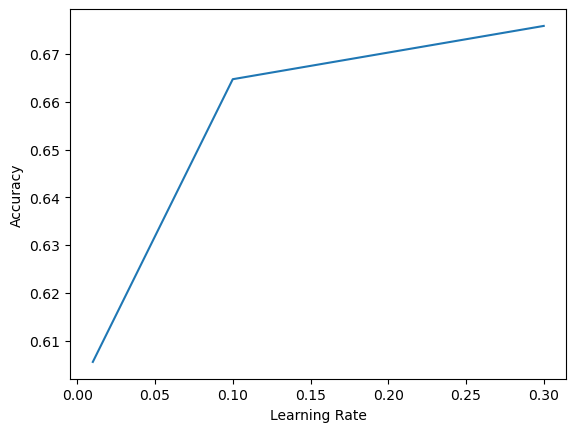

In [192]:
learning_rates = gs.cv_results_['param_model__eta']

sc_lr = {}
for sc, lr in zip(scores, learning_rates):
    if lr not in sc_lr:
        sc_lr[lr] = [[sc], sc]
    else:
        sc_lr[lr][0].append(sc)
        sc_lr[lr][1] = np.mean(sc_lr[lr][0])

sns.lineplot(x = sc_lr.keys(), y = [mean[1] for mean in sc_lr.values()]).set(
xlabel='Learning Rate', ylabel = 'Accuracy');

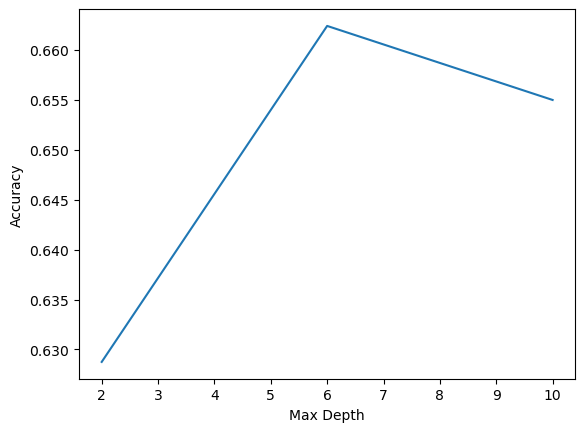

In [194]:
max_depth_list = gs.cv_results_['param_model__max_depth']

max_depth = {}
for sc, md in zip(scores, max_depth_list):
    if md not in max_depth:
        max_depth[md] = [[sc], sc]
    else:
        max_depth[md][0].append(sc)
        max_depth[md][1] = np.mean(max_depth[md][0])

sns.lineplot(x = max_depth.keys(), y = [mean[1] for mean in max_depth.values()]).set(
xlabel='Max Depth', ylabel = 'Accuracy');

In [28]:
n_estimators_list

masked_array(data=[300, 500, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object)

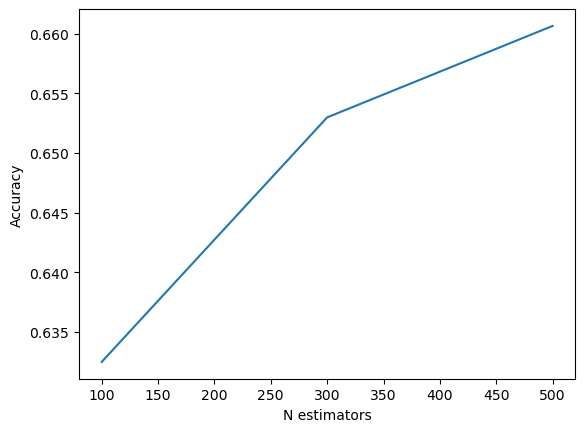

In [195]:
n_estimators_list = gs.cv_results_['param_model__n_estimators']

n_estimators = {}
for sc, ne in zip(scores, n_estimators_list):
    if ne not in n_estimators:
        n_estimators[ne] = [[sc], sc]
    else:
        n_estimators[ne][0].append(sc)
        n_estimators[ne][1] = np.mean(n_estimators[ne][0])

sns.lineplot(x = n_estimators.keys(), y = [mean[1] for mean in n_estimators.values()]).set(
xlabel='N estimators', ylabel = 'Accuracy');

## CNN

In [3]:
def get_audio_files(path:str):
    counter = 0
    files = []
    
    for file in os.listdir(path):
        if os.path.isdir(f"{path}/{file}"):
            files.extend(get_audio_files(f"{path}/{file}"))
        else:
            title, ext = os.path.splitext(f"{path}/{file}")
            if ext == '.wav':
                files.append(title + ext)
                counter += 1
    return files
    
        

audio_paths = get_audio_files('data')

In [100]:
audio_paths[0]

'data/fold2/203929-7-5-1.wav'

In [4]:
def get_mel_sgrams(files:list):
    mel_sgrams = {}
    for file in files:
        samples, sample_rate = librosa.load(file)
        sgram = librosa.stft(samples)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        mel_sgrams[file] = mel_sgram
    return mel_sgrams

In [5]:
mel_sgrams = get_mel_sgrams(audio_paths)

In [6]:
mel_sgrams['data/fold2/203929-7-5-1.wav'].shape

(128, 173)

In [7]:
#gets max number of columns in the spectrogram
max_length = 0

for i, sgram in enumerate(mel_sgrams.values()):
    if sgram.shape[1] > max_length:
        max_length = sgram.shape[1]
print(f"Max length of mel-spectrograms: {max_length}")

Max length of mel-spectrograms: 174


### Zero-padded spectrograms

Audio files have different durations, therefore the dimensions of the spectrograms are gonna be different. They need to be zero-padded, so the dimensions match and can be used in the CNN

In [8]:
def zero_pad_spectrogram(spectrogram, max_length):

    current_length = spectrogram.shape[1]
    padding = max_length - current_length

  # Creates a zero padding array
    padding_array = np.zeros((spectrogram.shape[0], padding))

  # Stack the spectrogram and padding array horizontally
    padded_spectrogram = np.hstack((spectrogram, padding_array))

    return padded_spectrogram


Structure of zero padded dictionary:

    N-fold

    |

    v

[Train], [Validation]

    |

    V

[X_train, X_val], [y_train, y_val]

In [91]:

zero_padded = {i: [[[], []], [[], []]] for i in range(1, 11)}

for path, sgram in mel_sgrams.items():
    zero_pad = zero_pad_spectrogram(sgram, max_length)
    file_name = path.split('/')[-1]
    target = df.loc[df['slice_file_name'] == file_name, 'classID'].values[0]
    fold = df.loc[df['slice_file_name'] == file_name, 'fold'].values[0]
    zero_padded[fold][1][0].append(zero_pad)
    zero_padded[fold][1][1].append(target)
    for i in range(1, 11):
        if i != fold:
            zero_padded[i][0][0].append(zero_pad)
            zero_padded[i][0][1].append(target)
    

In [93]:
#One hot encode the targets
ohe = OneHotEncoder(sparse_output = False)
for fold in zero_padded.values():
    fold[0][1] = ohe.fit_transform(np.array(fold[0][1]).reshape(-1, 1))
    fold[1][1] = ohe.fit_transform(np.array(fold[1][1]).reshape(-1, 1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [302]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Convolutional layers with ReLU activation and MaxPooling
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten for dense layers
    x = Flatten()(x)

    # Dense layers with ReLU activation and dropout for regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer with softmax activation for multi-class classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model

# Define model input shape based on spectrograms
input_shape = (128, 174, 1) 

# Number of targets
num_classes = 10

# Build the CNN model
model = build_cnn_model(input_shape, num_classes)

loss = []
accuracy = []
# Train model cross-validating pre-determined folds
for fold in range(1, 11):

    x_train = np.array(zero_padded[fold][0][0])
    y_train = zero_padded[fold][0][1]
    x_test = np.array(zero_padded[fold][1][0])
    y_test = zero_padded[fold][1][1]
    model.fit(x_train, y_train, epochs=20)

    # Evaluate the fold
    test_loss, test_acc = model.evaluate(x_test, y_test)
    
    loss.append(test_loss)
    accuracy.append(test_acc)
    
    print('Test accuracy:', test_acc)

Epoch 1/20


2024-02-15 22:20:37.552059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 21s 79ms/step - loss: 63.8766 - accuracy: 0.1253
Epoch 2/20
246/246 [==============================] - 19s 77ms/step - loss: 2.9102 - accuracy: 0.1379
Epoch 3/20
246/246 [==============================] - 19s 76ms/step - loss: 3.8886 - accuracy: 0.1435
Epoch 4/20
246/246 [==============================] - 19s 78ms/step - loss: 6.7171 - accuracy: 0.1445
Epoch 5/20
246/246 [==============================] - 19s 77ms/step - loss: 6.4214 - accuracy: 0.1431
Epoch 6/20
246/246 [==============================] - 19s 76ms/step - loss: 4.6096 - accuracy: 0.1435
Epoch 7/20
246/246 [==============================] - 19s 77ms/step - loss: 4.1776 - accuracy: 0.1444
Epoch 8/20
246/246 [==============================] - 19s 76ms/step - loss: 3.8591 - accuracy: 0.1403
Epoch 9/20
246/246 [==============================] - 19s 77ms/step - loss: 3.2766 - accuracy: 0.1445
Epoch 10/20
246/246 [==============================] - 19s 78ms/step - loss: 3.0805 - accura

2024-02-15 22:26:58.341650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 29ms/step - loss: 3.0803 - accuracy: 0.1420
Test accuracy: 0.142038956284523
Epoch 1/20
246/246 [==============================] - 20s 78ms/step - loss: 3.0652 - accuracy: 0.1369
Epoch 2/20
246/246 [==============================] - 19s 77ms/step - loss: 2.9773 - accuracy: 0.1475
Epoch 3/20
246/246 [==============================] - 19s 76ms/step - loss: 2.7881 - accuracy: 0.1460
Epoch 4/20
246/246 [==============================] - 19s 77ms/step - loss: 2.6781 - accuracy: 0.1418
Epoch 5/20
246/246 [==============================] - 19s 77ms/step - loss: 2.8262 - accuracy: 0.1455
Epoch 6/20
246/246 [==============================] - 19s 76ms/step - loss: 2.8441 - accuracy: 0.1475
Epoch 7/20
246/246 [==============================] - 19s 76ms/step - loss: 2.8877 - accuracy: 0.1511
Epoch 8/20
246/246 [==============================] - 19s 78ms/step - loss: 2.9184 - accuracy: 0.1427
Epoch 9/20
246/246 [==============================] - 19s 77ms/

244/244 [==============================] - 22s 88ms/step - loss: 26.4573 - accuracy: 0.1466
Epoch 16/20
244/244 [==============================] - 22s 89ms/step - loss: 34.0612 - accuracy: 0.1466
Epoch 17/20
244/244 [==============================] - 22s 88ms/step - loss: 31.8765 - accuracy: 0.1457
Epoch 18/20
244/244 [==============================] - 21s 88ms/step - loss: 31.2583 - accuracy: 0.1407
Epoch 19/20
244/244 [==============================] - 22s 89ms/step - loss: 29.8364 - accuracy: 0.1446
Epoch 20/20
30/30 [==============================] - 1s 36ms/step - loss: 18.3582 - accuracy: 0.1389
Test accuracy: 0.1388888955116272
Epoch 1/20
248/248 [==============================] - 23s 90ms/step - loss: 32.8370 - accuracy: 0.1470
Epoch 2/20
248/248 [==============================] - 22s 88ms/step - loss: 28.3117 - accuracy: 0.1481
Epoch 3/20
248/248 [==============================] - 22s 89ms/step - loss: 31.1127 - accuracy: 0.1463
Epoch 4/20
248/248 [============================

248/248 [==============================] - 22s 88ms/step - loss: 4.8871 - accuracy: 0.1462
Epoch 10/20
248/248 [==============================] - 22s 88ms/step - loss: 4.0601 - accuracy: 0.1513
Epoch 11/20
248/248 [==============================] - 22s 88ms/step - loss: 4.5680 - accuracy: 0.1435
Epoch 12/20
248/248 [==============================] - 22s 89ms/step - loss: 1152.3264 - accuracy: 0.1348
Epoch 13/20
248/248 [==============================] - 22s 88ms/step - loss: 14.5752 - accuracy: 0.1508
Epoch 14/20
248/248 [==============================] - 22s 88ms/step - loss: 11.6502 - accuracy: 0.1462
Epoch 15/20
248/248 [==============================] - 22s 88ms/step - loss: 15.6384 - accuracy: 0.1467
Epoch 16/20
248/248 [==============================] - 22s 88ms/step - loss: 30.2078 - accuracy: 0.1518
Epoch 17/20
248/248 [==============================] - 22s 88ms/step - loss: 13.4358 - accuracy: 0.1512
Epoch 18/20
248/248 [==============================] - 22s 89ms/step - loss: 

In [293]:
print('Accuracies per validation:', accuracy, '\n')
print('Mean accuracy:', np.array(accuracy).mean(), '\n')
print('Loss per validation:', loss, '\n')
print('Mean loss:', np.array(loss).mean(), '\n')

Accuracies per validation: [0.18098512291908264, 0.2015765756368637, 0.2875675857067108, 0.41515153646469116, 0.5256410241127014, 0.4617254137992859, 0.3329355716705322, 0.5235732197761536, 0.4522058963775635, 0.49581843614578247] 

Mean accuracy: 0.38771803826093676 

Loss per validation: [2.9479503631591797, 9.189982414245605, 38.66249084472656, 288.1620788574219, 2509.887451171875, 22392.0390625, 296829.8125, 490513.90625, 1230928.5, 2782438.75] 

Mean loss: 482595.18577661517 



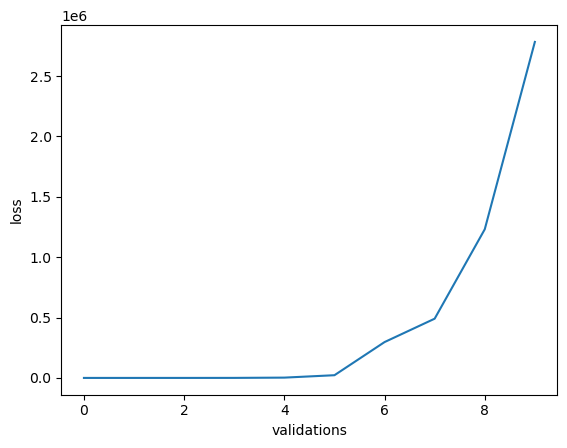

In [299]:
sns.lineplot(x = range(len(loss)), y = loss).set(xlabel = 'validations', ylabel = 'loss');

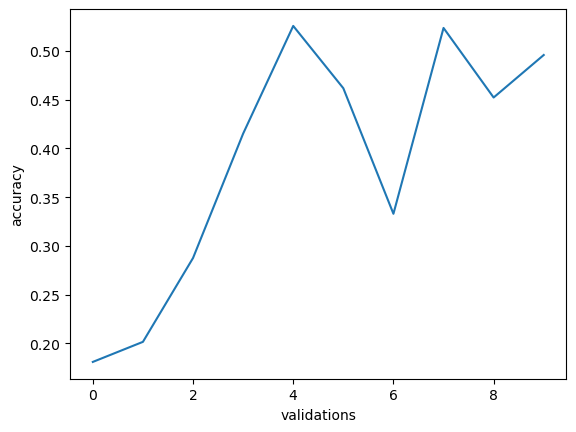

In [301]:
sns.lineplot(x = range(len(accuracy)), y = accuracy).set(xlabel = 'validations', ylabel = 'accuracy');